In [ ]:
# %%
import ot
import numpy as np
import otmol as otm
import pandas as pd
from openbabel import pybel
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import os
# %matplotlib widget

In [2]:
def RMSD(V, W):
    """ 
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    """
    N = V.shape[0]
    return np.sqrt(np.sum((V-W)**2)/N)

def compare_lists(list1, list2):
    """
    Compare two lists and return the indices and elements where they differ.

    Args:
        list1 (list): The first list to compare.
        list2 (list): The second list to compare.

    Returns:
        list: A list of tuples, where each tuple contains the index and the differing elements
              in the format (index, element_from_list1, element_from_list2).
    """
    differences = []
    # Compare elements up to the length of the shorter list
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            differences.append((i, list1[i], list2[i]))

    return differences

def parse_molecule_pairs(file_path, mol_type: str = 'water cluster'):
    """
    Parses a file containing molecule pairs separated by an underscore ('_').

    Parameters:
    ----------
    file_path : str
        Path to the file containing molecule pairs.

    Returns:
    -------
    list of lists
        A list where each element is a pair [molA, molB].
    """
    molecule_pairs = []
    with open(file_path, 'r') as file:
        if mol_type == 'water cluster' or mol_type == 'S1':
            for line in file:
                line = line.strip()  # Remove any leading/trailing whitespace
                if line:  # Skip empty lines
                    # Some lines are like "molA_molB_2", and some are like "molA_molB"
                    molecule_pairs.append([line.split('_')[0], line.split('_')[1]])
        if mol_type == 'FGG':
            next(file)  # Skip the first line
            for line in file:
                line = line.strip()
                if line:
                    molA, molB = line.split('-')
                    molecule_pairs.append([molA, molB])
    return molecule_pairs

[(2, 3, 0), (4, 5, 6)]
    Index                      Isomers_aligned  RMSD(Conv)  \
0       2   253_FGG99-aligned_to-252_FGG55.xyz       2.346   
1       3  254_FGG300-aligned_to-252_FGG55.xyz       3.076   
2       4  255_FGG252-aligned_to-252_FGG55.xyz       2.741   
3       5  256_FGG366-aligned_to-252_FGG55.xyz       2.744   
4       6  257_FGG215-aligned_to-252_FGG55.xyz       2.424   
5       7  258_FGG224-aligned_to-252_FGG55.xyz       2.676   
6       8  259_FGG380-aligned_to-252_FGG55.xyz       1.635   
7       9  260_FGG412-aligned_to-252_FGG55.xyz       2.364   
8      10  261_FGG444-aligned_to-252_FGG55.xyz       2.457   
9      11  262_FGG470-aligned_to-252_FGG55.xyz       2.671   
10     12   263_FGG80-aligned_to-252_FGG55.xyz       2.390   
11     13  264_FGG114-aligned_to-252_FGG55.xyz       1.981   
12     14  265_FGG357-aligned_to-252_FGG55.xyz       2.061   
13     15  266_FGG691-aligned_to-252_FGG55.xyz       3.149   

    RMSD(KM-ByAtomName)  RMSD(KM-ByAtomType)  

In [77]:
def Experiment(data_path: str = None,mol_pair: list = None, method: str = 'fgw', #alpha: float = 0.1, 
               alpha_list: list = None, D_matrix: str = 'geodesic',
               #coef_DD: list = None
               ):
    """
    Experiment with ArbAlign data.
    """
    results = []
    # Load the molecule pairs from the specified file
    for nameA, nameB in mol_pair:
        molA = next(pybel.readfile('xyz', os.path.join(data_path, nameA + '.xyz')))
        molB = next(pybel.readfile('xyz', os.path.join(data_path, nameB + '.xyz')))
        # Basic processing of the molecules
        X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
        X_B, T_B, B_B = otm.tl.process_molecule(molB)
        # Compute the distance matrices
        C = otm.tl.molecule_physchem_distance(T_A, T_B)
        C = np.where(C>0, 1e12, C)
        D_A = otm.tl.geodesic_distance(X_A, B_A)
        D_B = otm.tl.geodesic_distance(X_B, B_B)
        DD_A = distance_matrix(X_A, X_A)
        DD_B = distance_matrix(X_B, X_B)

        if method == 'fgw':
        # Fused Gromov-Wasserstein
            rmsd_array = np.empty(len(alpha_list), dtype=float)
            P_array = np.empty(len(alpha_list), dtype=object)
            
            for i, alpha in enumerate(alpha_list):
                if D_matrix == 'geodesic':
                    P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method=method, alpha=alpha)
                if D_matrix == 'euclidean':
                    P = otm.tl.molecule_optimal_transport(C, DD_A, DD_B, method=method, alpha=alpha)

                X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
                rmsd_array[i] = RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)])
                P_array[i] = P
            # find the optimal alpha, rmsd, assignment
            rmsd = np.min(rmsd_array)
            optimal_alpha = alpha_list[np.argmin(rmsd_array)]
            optimal_P = P_array[np.argmin(rmsd_array)]
            optimal_assignment = np.argmax(optimal_P, axis=1)
        if len(np.unique(optimal_assignment)) != X_A.shape[0]: # check if the assignment is 1 to 1
            print('nameA', 'nameB', 'Warning: the assignment is not 1 to 1')
        if compare_lists(T_A, T_B[optimal_assignment]): # check if atom names are matched
            print('nameA', 'nameB', 'Warning: unmatched atom names exist')
        results.append({
            'nameA': nameA,
            'nameB': nameB,
            'RMSD({}+{})'.format(method, D_matrix): rmsd,
            '# atoms': X_A.shape[0],
            'alpha': optimal_alpha,
            'assignment': optimal_assignment,
            'atomname_diff': compare_lists(T_A, T_B[optimal_assignment])
        }) 
        print(nameA, nameB, rmsd)

    return pd.DataFrame(results)

In [83]:
data_path = "./DataArbAlign/FGG-Tripeptide"
#data_path = "./DataArbAlign/FGG"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='FGG')
otmol_res = Experiment(data_path, molecule_pairs, method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,1000))
#print(otmol_res)

252_FGG55 253_FGG99 1.7876994032557443
252_FGG55 254_FGG300 1.9404307123173092
252_FGG55 255_FGG252 2.030183890671386
252_FGG55 256_FGG366 2.293084610348439
252_FGG55 257_FGG215 1.49818967623898
252_FGG55 258_FGG224 0.7462840440918397
252_FGG55 259_FGG380 1.2754148103268519
252_FGG55 260_FGG412 1.6950179526579114
252_FGG55 261_FGG444 1.1422673356214297
252_FGG55 262_FGG470 1.3469703904831836
252_FGG55 263_FGG80 1.5382304895192618
252_FGG55 264_FGG114 1.5439659584903764
252_FGG55 265_FGG357 1.5867602989661076
252_FGG55 266_FGG691 2.1822439707012604


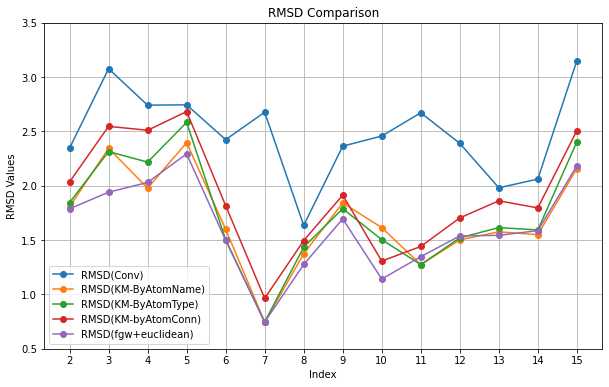

In [87]:
# Concatenate otmol_res and df along the columns
arbalign_res = pd.read_csv(os.path.join(data_path, 'rmsd-2017.dat'), sep='\s+')
combined_df = pd.concat([otmol_res, arbalign_res], axis=1)
# Plot the specified columns against the Index column
columns_to_plot = ["RMSD(Conv)", "RMSD(KM-ByAtomName)", "RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", "RMSD(fgw+euclidean)"]

plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(range(2,16), combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0.5, 3.5)
plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

In [82]:
otmol_res

,nameA,nameB,RMSD(fgw+euclidean),# atoms,alpha,assignment,atomname_diff
0,252_FGG55,253_FGG99,1.797090,37,0.021021,"[10, 4, 2, 3, 9, 6, 5, 7, 8, 1, 0, 11, 15, 21,...",[]
1,252_FGG55,254_FGG300,1.940431,37,0.018619,"[2, 1, 0, 3, 4, 6, 5, 7, 8, 9, 10, 11, 15, 21,...",[]
2,252_FGG55,255_FGG252,2.030184,37,0.005606,"[2, 1, 0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[]
3,252_FGG55,256_FGG366,2.293085,37,0.023624,"[2, 1, 0, 3, 4, 6, 5, 7, 8, 9, 17, 11, 12, 25,...",[]
4,252_FGG55,257_FGG215,1.449874,37,0.155556,"[0, 1, 2, 3, 4, 6, 5, 7, 8, 9, 10, 11, 13, 12,...",[]
5,252_FGG55,258_FGG224,0.746284,37,0.001802,"[0, 1, 2, 3, 4, 6, 5, 7, 8, 9, 10, 11, 13, 12,...",[]
6,252_FGG55,259_FGG380,1.275415,37,0.028428,"[2, 1, 0, 6, 4, 3, 5, 7, 15, 9, 10, 11, 12, 13...",[]
7,252_FGG55,260_FGG412,1.695018,37,0.079880,"[10, 4, 0, 6, 9, 13, 5, 7, 8, 1, 2, 11, 12, 3,...",[]
8,252_FGG55,261_FGG444,1.142267,37,0.000801,"[0, 1, 2, 3, 4, 6, 5, 7, 8, 9, 10, 11, 13, 12,...",[]
9,252_FGG55,262_FGG470,1.346970,37,0.002402,"[0, 1, 2, 5, 4, 3, 6, 7, 8, 9, 10, 11, 12, 13,...",[]


In [ ]:
for item in otmol_res['assignment']:
    print(len(item))

In [ ]:
for i in otmol_res['atomname_diff']:
    print(i)

In [9]:
"""
data_path = "./DataArbAlign/S1-MA-W1"
#data_path = "./DataArbAlign/FGG"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='S1')
Experiment(molecule_pairs, method='fgw', alpha=0.4)"
"""

'\ndata_path = "./DataArbAlign/S1-MA-W1"\n#data_path = "./DataArbAlign/FGG"\nmol_pair_list_path = os.path.join(data_path, \'list\')\nmolecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type=\'S1\')\nExperiment(molecule_pairs, method=\'fgw\', alpha=0.4)"\n'

In [75]:
# %%
# Read the molecules
molA = next(pybel.readfile("xyz", "./DataArbAlign/FGG-Tripeptide/252_FGG55.xyz"))
molB = next(pybel.readfile("xyz", "./DataArbAlign/FGG-Tripeptide/253_FGG99.xyz"))
#molA = next(pybel.readfile("xyz", "./DataArbAlign/S1-MA-W1/s1maw1-1.xyz"))

1.7970896157661829
['O' 'C' 'O' 'H' 'C' 'H' 'H' 'N' 'H' 'C' 'O' 'C' 'H' 'H' 'N' 'H' 'C' 'O'
 'C' 'N' 'H' 'H' 'H' 'C' 'H' 'H' 'C' 'C' 'H' 'C' 'H' 'C' 'H' 'C' 'H' 'C'
 'H']
['O' 'C' 'O' 'H' 'C' 'H' 'H' 'N' 'H' 'C' 'O' 'C' 'H' 'H' 'N' 'H' 'C' 'O'
 'C' 'N' 'H' 'H' 'H' 'C' 'H' 'H' 'C' 'C' 'H' 'C' 'H' 'C' 'H' 'C' 'H' 'C'
 'H']
[]


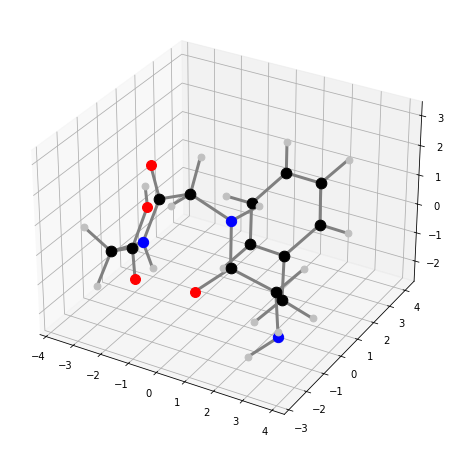

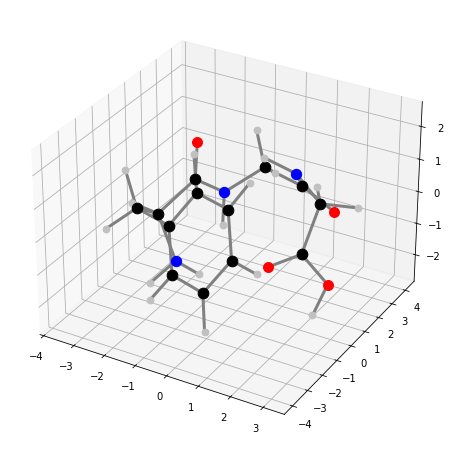

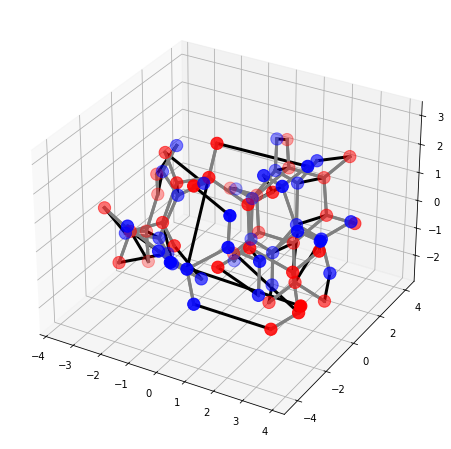

In [81]:
# %%
def permutation_to_matrix(permutation):
    """
    Converts a permutation list to a permutation matrix.
    
    Args:
        permutation (list or array): A list or array representing the permutation.
                                     For example, [2, 0, 1] means index 0 maps to 2, index 1 maps to 0, etc.
    
    Returns:
        numpy.ndarray: A permutation matrix.
    """
    n = len(permutation)
    matrix = np.zeros((n, n), dtype=int)
    for i, j in enumerate(permutation):
        matrix[i, j] = 1
    return matrix
# Basic processing of the molecules
X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
X_B, T_B, B_B = otm.tl.process_molecule(molB)
otm.pl.plot_molecule(X_A, T_A, B_A, coloring = 'type', sizing = 'type')
otm.pl.plot_molecule(X_B, T_B, B_B, coloring = 'type', sizing = 'type')
P = permutation_to_matrix(otmol_res['assignment'][0])
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P) 
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(T_A)
print(T_B[np.argmax(P, axis=1)])
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P, weight_cutoff=0.01)
plt.show()


In [27]:
# %%
C = otm.tl.molecule_physchem_distance(T_A, T_B)
D_A = otm.tl.geodesic_distance(X_A, B_A)
D_B = otm.tl.geodesic_distance(X_B, B_B)

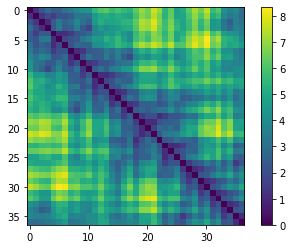

In [30]:
# %%
# Fused Gromov-Wasserstein
DD_A = distance_matrix(X_A, X_A)
DD_B = distance_matrix(X_B, X_B)
P = otm.tl.molecule_optimal_transport(C, D_A+17*DD_A, D_B+17*DD_B, method='fgw', alpha=0.1)
plt.show()
plt.imshow(DD_A)
plt.colorbar()

2.4043992558309104
[(0, 'O', 'H'), (5, 'H', 'O'), (8, 'H', 'C'), (9, 'C', 'H'), (14, 'N', 'C'), (17, 'O', 'N'), (18, 'C', 'H'), (19, 'N', 'C'), (23, 'C', 'N'), (25, 'H', 'O')]


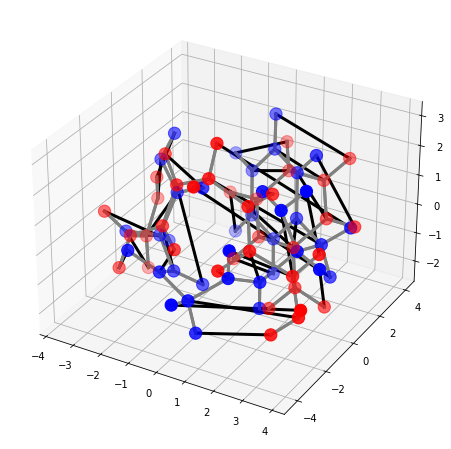

In [31]:
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P) 
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P, weight_cutoff=0.01)
plt.show()

2.0715502578376968


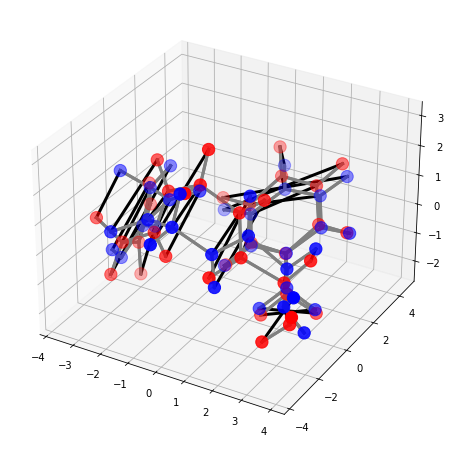

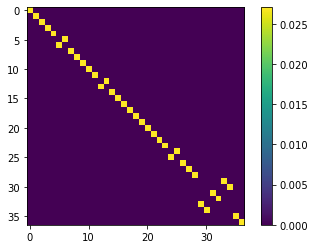

In [15]:
# %%
# Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='gw', alpha=0.9)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()


No more edges in the graph.
1.7280014712335232


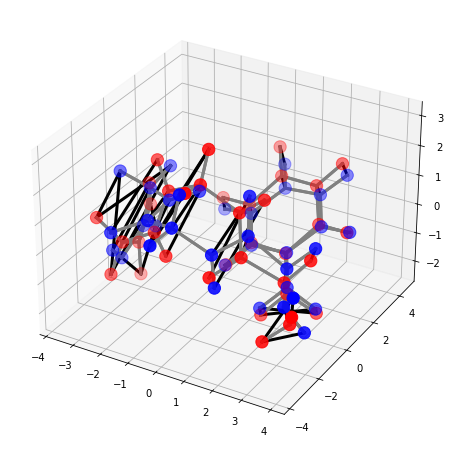

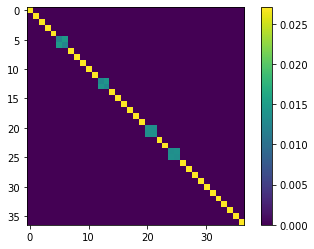

In [16]:
# %%
# Supervised Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='sgw', sgw_cutoff=5)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()

# of potential non-zeros in P: 210
1.7280103211713007
[]


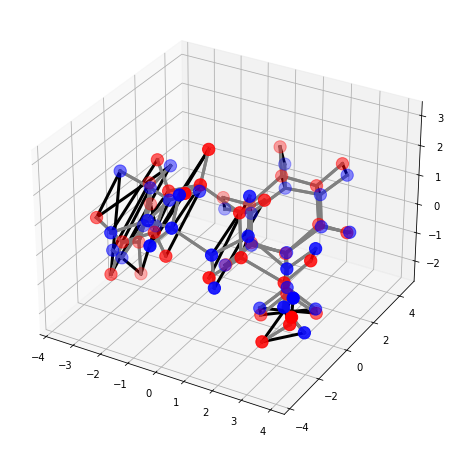

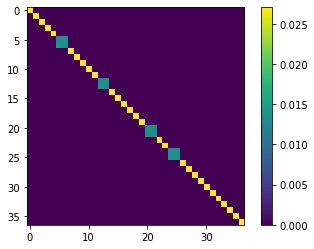

In [17]:
# %%
# Fused supervised Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='fsgw', sgw_cutoff=5, alpha=0.5)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()